In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import time
import DNN
%matplotlib inline

### Load the data

In [49]:
details = json.loads(open("details.json", "r").read())
X_data_path = details['coin'] + "_" + details['interval'] + "_data.csv"
Y_data_path = details['coin'] + "_" + details['prediction'] + "_data.csv"

X_data_raw = pd.read_csv(X_data_path)
Y_data_raw = pd.read_csv(Y_data_path)

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

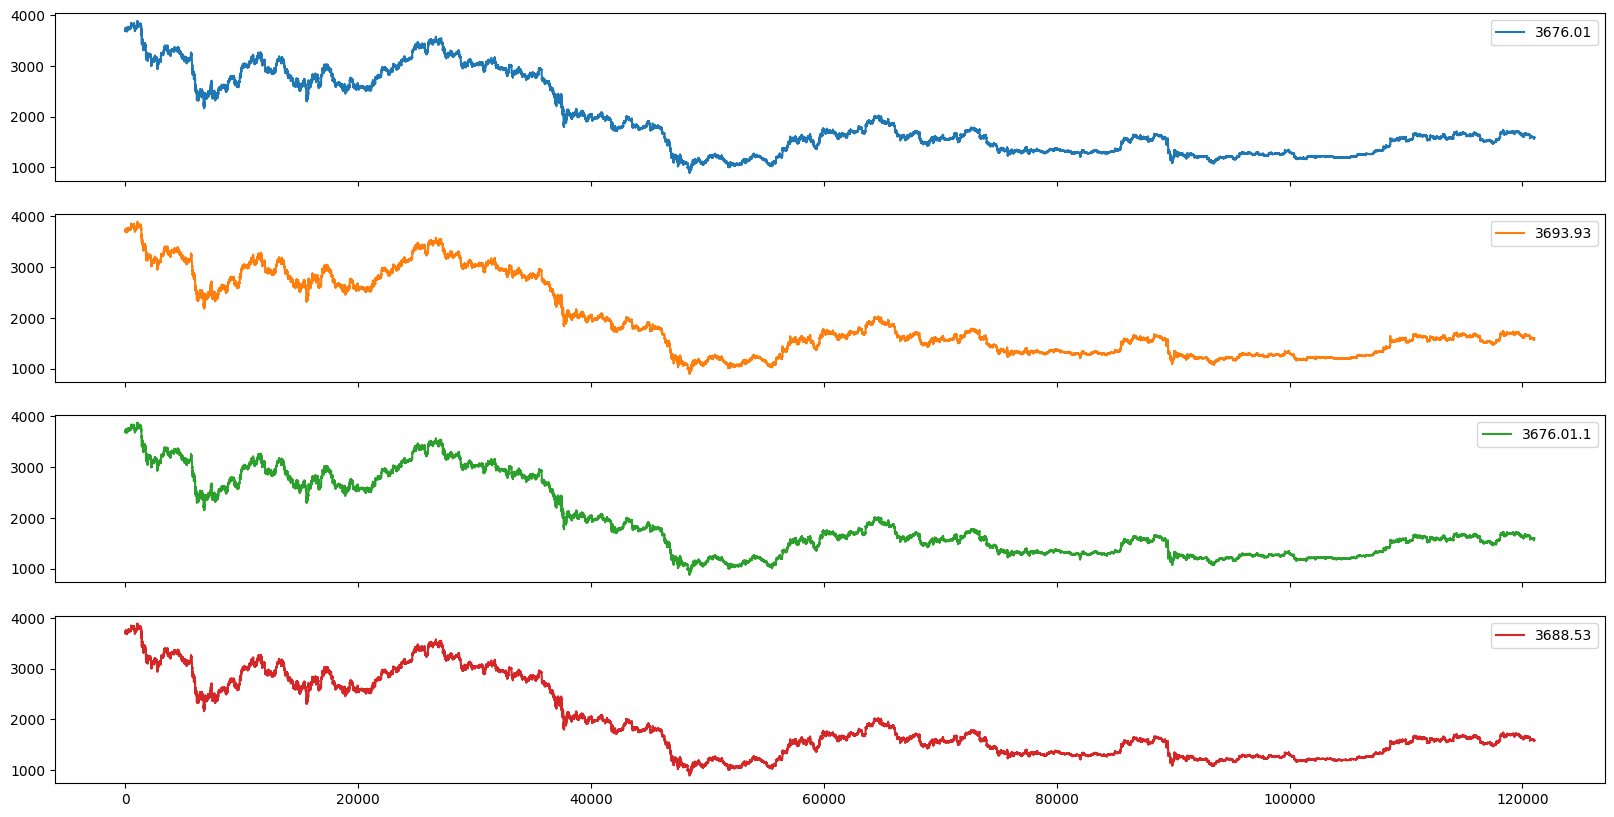

In [50]:
#get only columns: open,	high,	low,	close
X_data_raw = X_data_raw.iloc[:,2:6]
Y_data_raw = Y_data_raw.iloc[:,2:6]

#show data with each column is a different color
X_data_raw.plot(subplots=True, figsize=(20,10))


In [51]:
#to numpy 
X_data_raw = X_data_raw.to_numpy()
Y_data_raw = Y_data_raw.to_numpy()


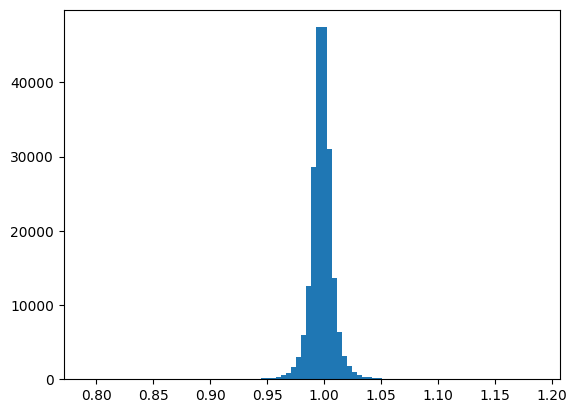

In [58]:
#normalize data


Y_data_raw = Y_data_raw[1:,:] / Y_data_raw[:-1,:]
''' Get the delta of the price, and normalize it by the previous price'''
#plot histogram of the data
hist, bin_edges = np.histogram(Y_data_raw, bins=100)
plt.bar(bin_edges[:-1], hist, width = 0.01)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()


In [ ]:
hist, bin_edges = np.histogram(Y_data_raw, bins=10)

# Get the indices of the 5 highest values in the histogram
top_indices = np.argsort(hist)[-5:]

# Get the bin edges for the corresponding indices
top_bin_edges = np.take(bin_edges, top_indices)

# Get the range of the 5 most common data
range_of_most_common_data = (np.min(top_bin_edges), np.max(top_bin_edges))

In [61]:
#get the most 5 common ranges
hist, bin_edges = np.histogram(Y_data_raw, bins=100)
hist = hist.tolist()
bin_edges = bin_edges.tolist()
hist = hist[1:]
bin_edges = bin_edges[1:]
hist, bin_edges = zip(*sorted(zip(hist, bin_edges), reverse=True))
hist = hist[:5]
bin_edges = bin_edges[:5]
print(bin_edges)
np.sort(bin_edges)



(0.9975917179476597, 1.0019437843875632, 0.9932396515077562, 1.0062958508274666, 0.9888875850678527)


array([0.98888759, 0.99323965, 0.99759172, 1.00194378, 1.00629585])